# DProvDB Experimental Evaluation

We would like to understand DProvDB's performance via empirical study.

## End-to-end Comparison

First we would like to perform an end-to-end comparison of DProvDB against baseline systems.

We have the following baselines:

- DProvDB minus additiveGM (Vanilla mechanism in our paper)
- Chorus
- DProvDB minus cached views (i.e., enabling Chorus with Provenance table)
- Simulating PrivateSQL 

Note that the key idea in PrivateSQL is to generate synopses for pre-determined views and answer queries using synopses.
The overall privacy budget is split to generate the synopses in advance.
One prominent way to allocate budget to views, as mentioned in PrivateSQL paper, is fair allocation.
That is to split the budget w.r.t the sensitivity of the views s.t. the expected error on each view is the same.
Since PrivateSQL system is not open source, we use our system with a specific setting to simulate PrivateSQL.

Each experiment is run for 4 times, we plot the mean and the variance as evaluation results.

In [1]:
# load package and fonts

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(font="Helvetica", rc={"figure.figsize":(4, 3)})
sns.set_theme(style="white")
sns.set_style('ticks')
sns.set_context("paper", font_scale=1.3, rc={"lines.linewidth": 1.75})

1) RRQ, over Adult dataset

In [2]:
# load data

report = pd.read_csv('../data/RRQ_adult_end_to_end.csv', sep=';')

report = report.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
report.columns = report.columns.str.strip()


# processing list strings

def parse_list(s):
    if isinstance(s, str) and s.startswith('List'):
        return [float(x) for x in s[5: -1].split(",")]
    else:
        return s

report = report.applymap(parse_list)

report.loc[(report["viewConstraintFlag"] == "static fixed-normalized: 1.0") & (report["mechanism"] == "baseline"), "mechanism"] = "PrivateSQL"
report.loc[(report["viewConstraintFlag"] == "static fixed-normalized: 1.0") & (report["mechanism"] == "PrivateSQL"), "viewConstraintFlag"] = "dynamic fixed-normalized: 1.0"

report.head(5)

,dataset,mechanism,task,viewConstraintFlag,budget,utility,totalNoOfQueries,analystConstraints,setup_time,execution_time,utility_breakdown,DCFG,accountant,accountant_breakdown,view_breakdown,avgAccuracy,runIndex,randomness
0,adult,aGM,RRQ_round-robin,dynamic fixed-aGM: 1.0,0.4,2075,8000,"[0.044444444444444446, 0.4]",5983.438429,11642.916822,"[592.0, 1483.0]",10348.375974,0.400599,"[0.0, 0.40059890747070315]","[0.0, 0.0, 0.20742216110229492, 0.0, 0.0, 0.0,...",1316.1624096385542,1,1025
1,adult,baseline,RRQ_round-robin,dynamic fixed-normalized: 1.0,0.4,1100,8000,"[0.04, 0.36]",5983.438429,6512.695735,"[0.0, 1100.0]",7236.691552,0.241795,"[0.0, 0.24179543495178227]","[0.0, 0.0, 0.24179543495178227, 0.0, 0.0, 0.0,...",2153.8263636363636,1,1025
2,adult,PrivateSQL,RRQ_round-robin,dynamic fixed-normalized: 1.0,0.4,0,8000,"[0.04, 0.36]",5983.438429,2032.601078,"[0.0, 0.0]",0.000000,0.000000,"[0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,1,1025
3,adult,Chorus,RRQ_round-robin,static fixed-normalized: 1.0,0.4,1,8000,"[0.04, 0.36]",5983.438429,2351.313866,"[1.0, 0.0]",1.000000,0.241904,"[0.24190406799316402, 0.0]","[0.0, 0.0, 0.24190406799316402, 0.0, 0.0, 0.0,...",3000.0,1,1025
4,adult,ChorusP,RRQ_round-robin,static fixed-normalized: 1.0,0.4,1,8000,"[0.04, 0.36]",5983.438429,1821.688022,"[0.0, 1.0]",6.578811,0.241904,"[0.0, 0.24190401077270507]","[0.0, 0.0, 0.24190401077270507, 0.0, 0.0, 0.0,...",3000.0,1,1025


In [3]:
# processing data

mechanism_mapping = {"aGM": "DProvDB", "baseline": "Vanilla", "Chorus": "Chorus", "ChorusP": "ChorusP", "PrivateSQL": "sPrivateSQL"}

epsilon_mapping = {0.4: "$\epsilon=0.4$", 0.8: "$\epsilon=0.8$", 1.6: "$\epsilon=1.6$", 3.2: "$\epsilon=3.2$", 6.4: "$\epsilon=6.4$"}

def processing_data(df, dataset, task, metric, workload_size, constraint_setting = "dynamic fixed: 1.0", mech_dt = ["aGM", "baseline", "PrivateSQL", "Chorus", "ChorusP"]):
    
    filtered_df = df[(df["dataset"]==dataset) & (df["task"]==task)]
            
    ret_dt = {}

    for mech in mech_dt:
                
        for eps in sorted(set(filtered_df['budget'])):
            
            filtered_df_eps = filtered_df[filtered_df['budget']==eps]
            
            if metric == "utility" or metric == "DCFG":
                ret_dt[(mechanism_mapping[mech], epsilon_mapping[eps])] = list(filtered_df_eps[filtered_df_eps['mechanism']==mech][metric].values)
            elif metric == "nDCFG":
                DCFG = list(filtered_df_eps[filtered_df_eps['mechanism']==mech]["DCFG"].values)
                utility = list(filtered_df_eps[filtered_df_eps['mechanism']==mech]["utility"].values)
                ret_dt[(mechanism_mapping[mech], epsilon_mapping[eps])] = [i / j  for i, j in zip(DCFG, utility)]
            elif metric == "utilization":
                accountant = list(filtered_df_eps[filtered_df_eps['mechanism']==mech]["accountant"].values)
                budget = list(filtered_df_eps[filtered_df_eps['mechanism']==mech]["budget"].values)
                ret_dt[(scenario_mapping[case], epsilon_mapping[eps])] = [i / j for i, j in zip(accountant, budget)]
    
    return ret_dt


# test
# processing_data(pd.concat([report.iloc[:960], report.iloc[2881:]]), "adult", "RRQ_round-robin", "utility", 8000)


/tmp/ipykernel_85316/3174524998.py:24: RuntimeWarning: invalid value encountered in scalar divide
  ret_dt[(mechanism_mapping[mech], epsilon_mapping[eps])] = [i / j  for i, j in zip(DCFG, utility)]


{('DProvDB', '$\\epsilon=0.4$'): [2075, 401, 2129, 2036], ('DProvDB', '$\\epsilon=0.8$'): [2156, 2218, 2449, 2499], ('DProvDB', '$\\epsilon=1.6$'): [3469, 3463, 3470, 3521], ('DProvDB', '$\\epsilon=3.2$'): [5159, 5145, 5178, 5157], ('DProvDB', '$\\epsilon=6.4$'): [5569, 5551, 5577, 5567], ('Vanilla', '$\\epsilon=0.4$'): [1100, 136, 582, 258], ('Vanilla', '$\\epsilon=0.8$'): [1131, 183, 738, 422], ('Vanilla', '$\\epsilon=1.6$'): [1441, 1712, 1036, 1890], ('Vanilla', '$\\epsilon=3.2$'): [3668, 2765, 2465, 2916], ('Vanilla', '$\\epsilon=6.4$'): [3997, 3080, 3427, 3332], ('sPrivateSQL', '$\\epsilon=0.4$'): [0, 0, 0, 0], ('sPrivateSQL', '$\\epsilon=0.8$'): [0, 0, 0, 0], ('sPrivateSQL', '$\\epsilon=1.6$'): [0, 0, 0, 0], ('sPrivateSQL', '$\\epsilon=3.2$'): [2, 0, 0, 4], ('sPrivateSQL', '$\\epsilon=6.4$'): [2580, 2608, 2622, 2586], ('Chorus', '$\\epsilon=0.4$'): [1, 1, 1, 1], ('Chorus', '$\\epsilon=0.8$'): [3, 2, 2, 2], ('Chorus', '$\\epsilon=1.6$'): [5, 4, 3, 3], ('Chorus', '$\\epsilon=3.2$')

/tmp/ipykernel_85316/1806489196.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(["DProvDB", "Vanilla", "PrivateSQL", "Chorus", "ChorusP"], fontsize=10)
/tmp/ipykernel_85316/1806489196.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[3].set_xticklabels(["DProvDB", "Vanilla", "PrivateSQL", "Chorus", "ChorusP"], fontsize=10)


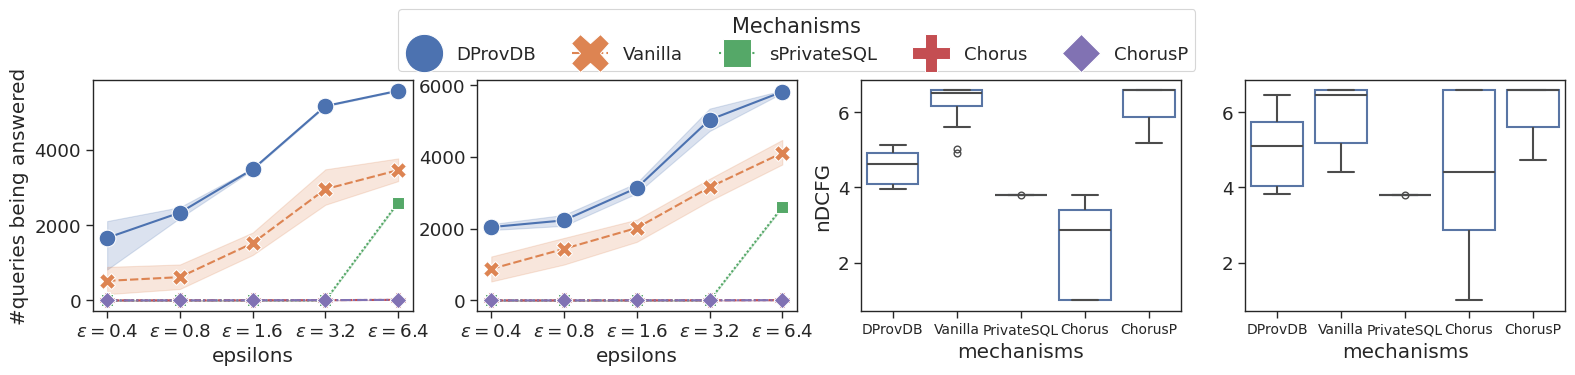

In [4]:
# plotting

# get data
adult_rr_utility = processing_data(report, "adult", "RRQ_round-robin", "utility", 20000)
adult_r_utility = processing_data(report, "adult", "RRQ_random", "utility", 20000)

adult_rr_fairness = processing_data(report, "adult", "RRQ_round-robin", "nDCFG", 20000)
adult_r_fairness = processing_data(report, "adult", "RRQ_random", "nDCFG", 20000)

sns.set(font="Helvetica", rc={"figure.figsize":(4, 3)})
sns.set_theme(style="white")
sns.set_style('ticks')
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 3})

# drawing figures
fig, axes = plt.subplots(ncols=4,figsize=(19, 3))
print(adult_rr_utility)

data = pd.Series(adult_rr_utility).reset_index()
data.columns = ['mechanisms', 'epsilons', 'utility']
data = data.explode("utility").reset_index().drop(columns=['index'])
line = sns.lineplot(data=data, x='epsilons', y='utility', hue='mechanisms', linewidth=1.5, ax=axes[0], style="mechanisms", markers=True, markersize=12, dashes=True)
sns.move_legend(axes[0], "lower center", bbox_to_anchor=(2.2, 1), ncol=5, title="Mechanisms", frameon=True, markerscale=2.3, fontsize=13, title_fontsize=15)
axes[0].set(ylabel="#queries being answered")



data = pd.Series(adult_r_utility).reset_index()
data.columns = ['mechanisms', 'epsilons', 'utility']
data = data.explode("utility").reset_index().drop(columns=['index'])
sns.lineplot(data=data, x='epsilons', y='utility', hue='mechanisms', linewidth=1.5, ax=axes[1], legend=False, style="mechanisms", markers=True, markersize=12, dashes=True)
axes[1].set(ylabel=None)

hatches = ['/', '..', 'xx', '\\', '|']

data = pd.Series(adult_rr_fairness).reset_index()
data.columns = ['mechanisms', 'epsilons', 'nDCFG']
data = data.explode("nDCFG").reset_index().drop(columns=['index'])
sns.boxplot(data=data, x='mechanisms', y='nDCFG', linewidth=1.5, ax=axes[2])
axes[2].set_xticklabels(["DProvDB", "Vanilla", "PrivateSQL", "Chorus", "ChorusP"], fontsize=10)
patches = [patch for patch in axes[2].patches if type(patch) == mpl.patches.PathPatch]
h = hatches * (len(patches) // len(hatches))
for patch, hatch in zip(patches, h):
#     patch.set_hatch(hatch)
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor('none')


data = pd.Series(adult_r_fairness).reset_index()
data.columns = ['mechanisms', 'epsilons', 'nDCFG']
data = data.explode("nDCFG").reset_index().drop(columns=['index'])
sns.boxplot(data=data, x='mechanisms', y='nDCFG', linewidth=1.5, ax=axes[3])
axes[3].set(ylabel=None)
axes[3].set_xticklabels(["DProvDB", "Vanilla", "PrivateSQL", "Chorus", "ChorusP"], fontsize=10)
patches = [patch for patch in axes[3].patches if type(patch) == mpl.patches.PathPatch]
h = hatches * (len(patches) // len(hatches))
for patch, hatch in zip(patches, h):
#     patch.set_hatch(hatch)
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor('none')


plt.savefig('end_to_end.pdf', dpi=600, bbox_inches='tight')



The above 4 figs: *a) utility (#queries being answered) v.s. epsilon, round-robin; b) utility (#queries being answered) v.s. epsilon, randomized; c) fairness (nDCFG) v.s. epsilon, round-robin; d) fairness (nDCFG) v.s. epsilon, randomized.*


**Round-robin** means data analysts submit queries in a round-robin manner.
**Randomized** means data analysts submit queries in a randomized manner.

The experiment is evaluated with only 2 data analysts.

For **Utility**, we use the number of queries are answered in total as the metric. For **Fairness**, we use the normalized DCFG (nDCFG) as the evaluation metric.
We would like to capture the relationship between the data analysts' privilege level and the individual utility.
Thus we coin DCFG, which is an entropy-related metric that gets higher when the data analyst's utility is positively proportionaly to their privilege level.
Note that DCFG is naturally higher when the overall utility for a mechanism is higher than another.
The nDCFG metric normalizes the DCFG by the total number of queries being answered by this mechanism.

Takeaway messages from this experiment:
1) DProvDB outperforms all competing systems, in both round-robin and randomized scenarios;
2) With **only 2** data analysts, additive Gaussian mechanism performs marginally better than baseline mechanism;
3) Enabling the provenance table (and setting row constraints) can improve fairness among data analysts.

## Component Evaluation

Here are some hypotheses, w.r.t different components in DProvDB, that we would like to empirically verify.

### Hypothesis 1 (Additive GM). Given the same overall privacy budget, DProvDB with additiveGM performs better than with baseline mechanism in terms of utility.

AdditiveGM enables the method that reuse the same global synopsis to generate local synopsis when different data analysts ask a similar or same query. Using additiveGM the system should have more queries being answered than using baseline mechanism.
*More particularly, we would like to verify how the utility gap between two mechanisms changes when the number of data analysts increases in the system.*

In this experiment, all data analysts have the same privilege level. We increase the number of data analysts from 1 to 4. 

In [5]:
# load data

report = pd.read_csv('../data/RRQ_adult_analyst_constraints.csv', sep=';')

report = report.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
report.columns = report.columns.str.strip()


# processing list strings

def parse_list(s):
    if isinstance(s, str) and s.startswith('List'):
        return [float(x) for x in s[5: -1].split(",")]
    else:
        return s

report = report.applymap(parse_list)

report.loc[(report["viewConstraintFlag"] == "static fixed-normalized: 1.0") & (report["mechanism"] == "baseline"), "mechanism"] = "PrivateSQL"
report.loc[(report["viewConstraintFlag"] == "static fixed-normalized: 1.0") & (report["mechanism"] == "PrivateSQL"), "viewConstraintFlag"] = "dynamic fixed-normalized: 1.0"

report.head(5)

,dataset,mechanism,task,viewConstraintFlag,budget,utility,totalNoOfQueries,analystConstraints,setup_time,execution_time,utility_breakdown,DCFG,accountant,accountant_breakdown,view_breakdown,avgAccuracy,runIndex,randomness
0,adult,aGM,RRQ_round-robin,dynamic fixed-aGM: 1.0,3.2,4866,5000,"[3.2, 3.2]",3584.222782,17105.509515,"[2433.0, 2433.0]",18499.476994,3.218133,"[3.218133449554444, 0.0]","[0.506722640991211, 0.0, 0.5856754302978517, 0...",2564.661734,1,1025
1,adult,aGM,RRQ_round-robin,dynamic fixed-aGM: 1.0,3.2,7299,7500,"[3.2, 3.2, 3.2]",3584.222782,25779.536841,"[2433.0, 2433.0, 2433.0]",27749.215492,3.218133,"[3.218133449554444, 0.0, 0.0]","[0.506722640991211, 0.0, 0.5856754302978517, 0...",2564.661734,1,1025
2,adult,aGM,RRQ_round-robin,dynamic fixed-aGM: 1.0,3.2,9732,10000,"[3.2, 3.2, 3.2, 3.2]",3584.222782,32962.235488,"[2433.0, 2433.0, 2433.0, 2433.0]",36998.953989,3.218133,"[3.218133449554444, 0.0, 0.0, 0.0]","[0.506722640991211, 0.0, 0.5856754302978517, 0...",2564.661734,1,1025
3,adult,aGM,RRQ_round-robin,dynamic fixed-aGM: 1.0,3.2,12165,12500,"[3.2, 3.2, 3.2, 3.2, 3.2]",3584.222782,41436.961042,"[2433.0, 2433.0, 2433.0, 2433.0, 2433.0]",46248.692486,3.218133,"[3.218133449554444, 0.0, 0.0, 0.0, 0.0]","[0.506722640991211, 0.0, 0.5856754302978517, 0...",2564.661734,1,1025
4,adult,aGM,RRQ_round-robin,dynamic fixed-aGM: 1.0,3.2,14598,15000,"[3.2, 3.2, 3.2, 3.2, 3.2, 3.2]",3584.222782,48525.375473,"[2433.0, 2433.0, 2433.0, 2433.0, 2433.0, 2433.0]",55498.430983,3.218133,"[3.218133449554444, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.506722640991211, 0.0, 0.5856754302978517, 0...",2564.661734,1,1025


In [6]:
# processing data
mechanism_mapping = {"aGM": "DProvDB", "baseline": "Vanilla"}

analysts = [2, 3, 4, 5, 6]

epsilon = 3.2

epsilon_mapping = {0.8: "$\epsilon=0.8$", 1.6: "$\epsilon=1.6$", 3.2: "$\epsilon=3.2$", 6.4: "$\epsilon=6.4$"}

constraint_setting = {"dynamic fixed-aGM: 1.0": "-l_max", "dynamic fixed-normalized: 1.0": "-l_sum"}

def processing_data_aGM(df, dataset, task, epsilonOrAnalyst = "a"):
    
    filtered_df = df[(df["dataset"]==dataset) & (df["task"]==task)]
            
    ret_dt = {}
                
    if (epsilonOrAnalyst == "a"):
        for analyst in analysts:

            filtered_df_eps = filtered_df[(filtered_df['analystConstraints'].map(len)==analyst) & (filtered_df['budget']==epsilon)]

            ret_dt[("DProvDB-l_max", analyst)] = list(filtered_df_eps[(filtered_df_eps['mechanism']=="aGM") & (filtered_df_eps['viewConstraintFlag']=="dynamic fixed-aGM: 1.0")]['utility'].values)
            ret_dt[("DProvDB-l_sum", analyst)] = list(filtered_df_eps[(filtered_df_eps['mechanism']=="aGM") & (filtered_df_eps['viewConstraintFlag']=="dynamic fixed-normalized: 1.0")]['utility'].values)
            ret_dt[("Vanilla-l_sum", analyst)] = list(filtered_df_eps[(filtered_df_eps['mechanism']=="baseline") & (filtered_df_eps['viewConstraintFlag']=="dynamic fixed-normalized: 1.0")]['utility'].values)

    elif (epsilonOrAnalyst == "e"):
        for eps in epsilon_mapping.keys():
            filtered_df_eps = filtered_df[(filtered_df['analystConstraints'].map(len)==2) & (filtered_df['budget']==eps)]
            
            ret_dt[("DProvDB-l_max", epsilon_mapping[eps])] = list(filtered_df_eps[(filtered_df_eps['mechanism']=="aGM") & (filtered_df_eps['viewConstraintFlag']=="dynamic fixed-aGM: 1.0")]['utility'].values)
            ret_dt[("DProvDB-l_sum", epsilon_mapping[eps])] = list(filtered_df_eps[(filtered_df_eps['mechanism']=="aGM") & (filtered_df_eps['viewConstraintFlag']=="dynamic fixed-normalized: 1.0")]['utility'].values)
            ret_dt[("Vanilla-l_sum", epsilon_mapping[eps])] = list(filtered_df_eps[(filtered_df_eps['mechanism']=="baseline") & (filtered_df_eps['viewConstraintFlag']=="dynamic fixed-normalized: 1.0")]['utility'].values)

            
    return ret_dt


# test
# processing_data_aGM(report.iloc[897:2881], "adult", "RRQ_round-robin", "utility", 4000)


/u5/s693zhan/.conda/envs/DProvDB_build/lib/python3.8/site-packages/seaborn/utils.py:470: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/u5/s693zhan/.conda/envs/DProvDB_build/lib/python3.8/site-packages/seaborn/utils.py:470: UserWarning: The label '_container0' of <BarContainer object of 5 artists> starts with '_'. It is thus excluded from the legend.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/u5/s693zhan/.conda/envs/DProvDB_build/lib/python3.8/site-packages/seaborn/utils.py:470: UserWarning: The label '_container1' of <BarContainer object of 5 artists> starts with '_'. It is thus excluded from the legend.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/u5/s693zhan/.conda/envs/DProvDB_build/lib/python3.8/site-packages/seaborn/utils.py:470: UserWarning: The label '_container2' of <BarContainer object of 5 artists> starts with '_'. It is thus exclud

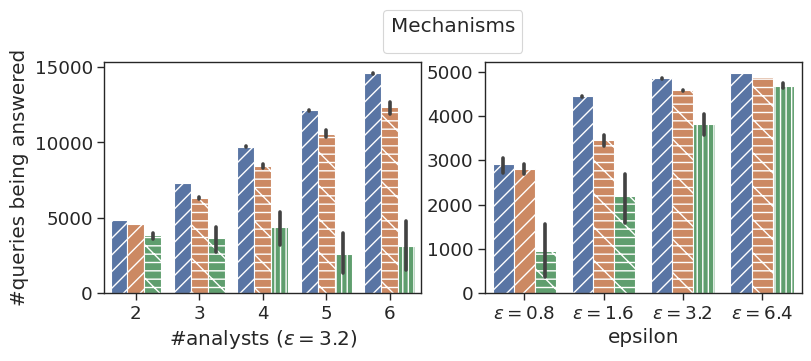

In [7]:
# plotting

# get data
adult_a_utility = processing_data_aGM(report, "adult", "RRQ_round-robin", "a")
adult_e_utility = processing_data_aGM(report, "adult", "RRQ_round-robin", "e")

# print(adult_a_utility)

hatches = ['//', '-\-', '|||']
sns.set(font="Helvetica", rc={"figure.figsize":(4, 3)})
sns.set_theme(style="white")
sns.set_style('ticks')
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.75})

# drawing figures
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))

data = pd.Series(adult_a_utility).reset_index()
data.columns = ['mechanisms', 'analysts', 'utility']
data = data.explode("utility")
bar = sns.barplot(data=data, x='analysts', y='utility', hue='mechanisms', ax=axes[0], )
axes[0].set(ylabel="#queries being answered")
axes[0].set(xlabel="#analysts ($\epsilon=3.2$)")
patches = [patch for patch in bar.patches]
h = [hatches[i//(len(patches) // len(hatches))] for i in range(len(patches))]
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)

# get container objects for each hue category
containers = bar.containers

# create legend handles
handles = []
for container in containers:
    for rect in container:
        handles.append(rect)
sns.move_legend(axes[0], "lower center", bbox_to_anchor=(1.1, 1), ncol=3, title="Mechanisms", frameon=True, handles=containers, )



data = pd.Series(adult_e_utility).reset_index()
data.columns = ['mechanisms', 'eps', 'utility']
data = data.explode("utility")
bar = sns.barplot(data=data, x='eps', y='utility', hue='mechanisms', ax=axes[1], )
axes[1].set(ylabel="#queries being answered")
axes[1].set(xlabel="epsilon")
axes[1].set(ylabel=None)
axes[1].legend_.remove()
patches = [patch for patch in bar.patches]
h = [hatches[i//(len(patches) // len(hatches))] for i in range(len(patches))]
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)




plt.savefig('agm.pdf', dpi=600, bbox_inches='tight')



The above 4 figs: *a) utility (#queries being answered) v.s. #analysts, round-robin; b) utility (#queries being answered) v.s. #analysts, randomized; c) utilization rate v.s. #analysts, round-robin; d) utilization rate v.s. #analysts, randomized.*

Utilization rate: the overall privacy budget utilization after the execution of the entire workload &mdash; defined as $\frac{\text{privacy accountant}}{\text{overall budget}}$;


Takeaway messages:
1) The utlity gap between DProvDB (aGM) and DProvDB (baseline) grows with the increase of the number of data analysts;
2) DProvDB (aGM) can potentially answer more queries when the number of data analysts grows;
3) In this experiments, the average utilization rate of DProvDB (aGM) is lower than baseline, suggesting that DProvDB better saves privacy budgets in executing this query workload.

### Hypothesis 2 (Cached Views/Synopses). Given the same overall privacy budget, mechanisms using cached views/synopses outperform those without caches in terms of utility, when the size of query workload increases.

In [8]:
# load data

report = pd.read_csv('../data/RRQ_adult_increasing_workload.csv', sep=';')

report = report.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
report.columns = report.columns.str.strip()


# processing list strings

def parse_list(s):
    if isinstance(s, str) and s.startswith('List'):
        return [float(x) for x in s[5: -1].split(",")]
    else:
        return s

report = report.applymap(parse_list)

report.loc[(report["viewConstraintFlag"] == "static fixed-normalized: 1.0") & (report["mechanism"] == "baseline"), "mechanism"] = "PrivateSQL"
report.loc[(report["viewConstraintFlag"] == "static fixed-normalized: 1.0") & (report["mechanism"] == "PrivateSQL"), "viewConstraintFlag"] = "dynamic fixed-normalized: 1.0"

report.head(5)

,dataset,mechanism,task,viewConstraintFlag,budget,utility,totalNoOfQueries,analystConstraints,setup_time,execution_time,utility_breakdown,DCFG,accountant,accountant_breakdown,view_breakdown,avgAccuracy,runIndex,randomness
0,adult,aGM,RRQ_round-robin,dynamic fixed-normalized: 1.0,0.4,84,100,"[0.08, 0.32]",3580.904449,335.596614,"[37.0, 47.0]",182.995335,0.357179,"[0.07772476196289063, 0.27945381164550787]","[0.06874290466308595, 0.0, 0.07772476196289063...",14949.833333,1,1025
1,adult,baseline,RRQ_round-robin,dynamic fixed-normalized: 1.0,0.4,39,100,"[0.08, 0.32]",3580.904449,250.530189,"[1.0, 38.0]",119.038781,0.338321,"[0.04688453674316406, 0.29143623352050785]","[0.0, 0.0, 0.14680099487304688, 0.0, 0.0, 0.0,...",14954.256410,1,1025
2,adult,Chorus,RRQ_round-robin,dynamic fixed-normalized: 1.0,0.4,3,100,"[0.08, 0.32]",3580.904449,268.700453,"[2.0, 1.0]",5.106284,0.329198,"[0.22872982025146482, 0.10046854019165039]","[0.0, 0.0, 0.32919836044311523, 0.0, 0.0, 0.0,...",14999.333333,1,1025
3,adult,ChorusP,RRQ_round-robin,dynamic fixed-normalized: 1.0,0.4,2,100,"[0.08, 0.32]",3580.904449,149.887320,"[0.0, 2.0]",6.212567,0.228730,"[0.0, 0.22872978210449213]","[0.0, 0.0, 0.22872978210449213, 0.0, 0.0, 0.0,...",14999.000000,1,1025
4,adult,aGM,RRQ_round-robin,dynamic fixed-normalized: 1.0,0.4,710,800,"[0.08, 0.32]",3580.904449,2597.839119,"[340.0, 370.0]",1489.324976,0.382699,"[0.07998550415039063, 0.30271301269531253]","[0.07464614868164066, 0.0, 0.07998550415039063...",14593.673239,1,1025


In [9]:
# processing data
mechanism_mapping = {"aGM": "DProvDB", "baseline": "Vanilla", "Chorus": "Chorus", "ChorusP": "ChorusP"}

workloads = [50, 400, 1000, 2000, 4000, 7000]

epsilon_mapping = {0.4: "$\epsilon=0.4$", 0.8: "$\epsilon=0.8$", 1.6: "$\epsilon=1.6$", 3.2: "$\epsilon=3.2$"}

def processing_data_caches(df, dataset, task, metric, number_of_analysts, eps, constraint_setting = "dynamic fixed-normalized: 1.0"):
    
    filtered_df = df[(df["dataset"]==dataset) & (df["task"]==task) & (df["budget"]==eps) & (df["viewConstraintFlag"]==constraint_setting)]
            
    ret_dt = {}

    for mech in mechanism_mapping.keys():
                
        for workload_size_per_analyst in workloads:
            
            workload_size = number_of_analysts * workload_size_per_analyst
            
            filtered_df_eps = filtered_df[(filtered_df['totalNoOfQueries']==workload_size)]
            
            if metric == "utility" or metric == "DCFG":
                ret_dt[(mechanism_mapping[mech], workload_size)] = list(filtered_df_eps[filtered_df_eps['mechanism']==mech][metric].values)
            elif metric == "nDCFG":
                DCFG = list(filtered_df_eps[filtered_df_eps['mechanism']==mech]["DCFG"].values)
                utility = list(filtered_df_eps[filtered_df_eps['mechanism']==mech]["utility"].values)
                ret_dt[(mechanism_mapping[mech], workload_size)] = [i / j for i, j in zip(DCFG, utility)]
            elif metric == "utilization":
                accountant = list(filtered_df_eps[filtered_df_eps['mechanism']==mech]["accountant"].values)
                budget = list(filtered_df_eps[filtered_df_eps['mechanism']==mech]["budget"].values)
                ret_dt[(mechanism_mapping[mech], workload_size)] = [i / j for i, j in zip(accountant, budget)]
    
    return ret_dt


# test
# processing_data_caches(report.iloc[:897], "adult", "RRQ_round-robin", "utility", 2, 0.4)


/u5/s693zhan/.conda/envs/DProvDB_build/lib/python3.8/site-packages/seaborn/utils.py:470: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/u5/s693zhan/.conda/envs/DProvDB_build/lib/python3.8/site-packages/seaborn/utils.py:470: UserWarning: The label '_container0' of <BarContainer object of 6 artists> starts with '_'. It is thus excluded from the legend.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/u5/s693zhan/.conda/envs/DProvDB_build/lib/python3.8/site-packages/seaborn/utils.py:470: UserWarning: The label '_container1' of <BarContainer object of 6 artists> starts with '_'. It is thus excluded from the legend.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/u5/s693zhan/.conda/envs/DProvDB_build/lib/python3.8/site-packages/seaborn/utils.py:470: UserWarning: The label '_container2' of <BarContainer object of 6 artists> starts with '_'. It is thus exclud

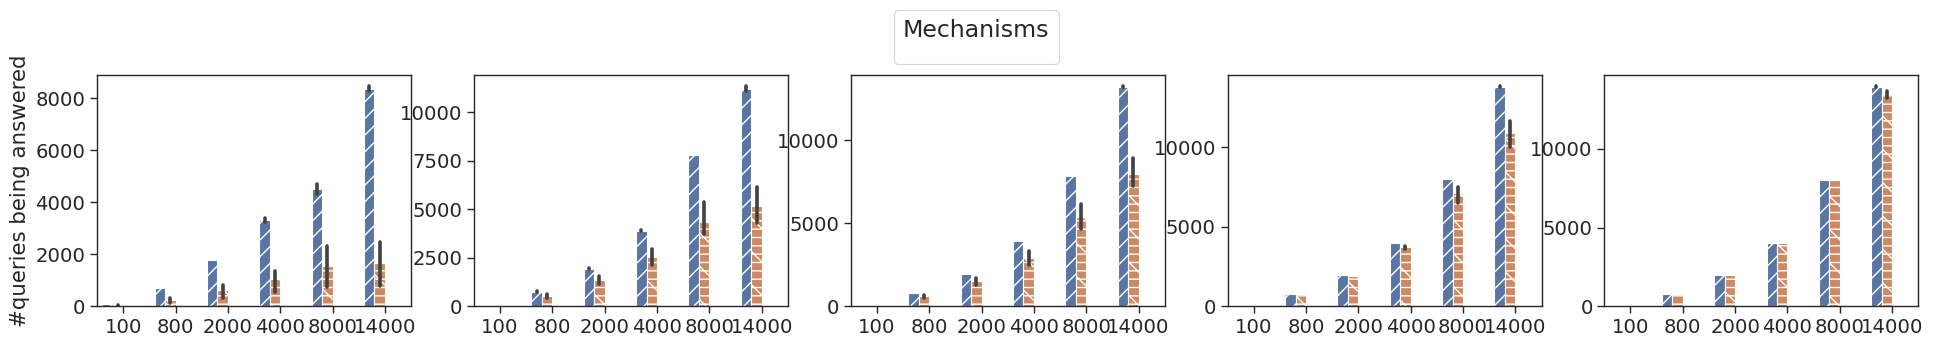

In [10]:
# plotting

report_caches = report

# get data
adult_rr_utility_04 = processing_data_caches(report_caches, "adult", "RRQ_round-robin", "utility", 2, 0.4)
adult_r_utility_04 = processing_data_caches(report_caches, "adult", "RRQ_random", "utility", 2, 0.4)

adult_rr_utility_08 = processing_data_caches(report_caches, "adult", "RRQ_round-robin", "utility", 2, 0.8)
adult_r_utility_08 = processing_data_caches(report_caches, "adult", "RRQ_random", "utility", 2, 0.8)

adult_rr_utility_16 = processing_data_caches(report_caches, "adult", "RRQ_round-robin", "utility", 2, 1.6)
adult_r_utility_16 = processing_data_caches(report_caches, "adult", "RRQ_random", "utility", 2, 1.6)

adult_rr_utility_32 = processing_data_caches(report_caches, "adult", "RRQ_round-robin", "utility", 2, 3.2)
adult_r_utility_32 = processing_data_caches(report_caches, "adult", "RRQ_random", "utility", 2, 3.2)

adult_rr_utility_64 = processing_data_caches(report_caches, "adult", "RRQ_round-robin", "utility", 2, 6.4)
adult_r_utility_64 = processing_data_caches(report_caches, "adult", "RRQ_random", "utility", 2, 6.4)

# adult_rr_utilization_04 = processing_data_fairness(report_caches, "adult", "RRQ_round-robin", "utilization", 2, 0.4)
# adult_r_utilization_04 = processing_data_fairness(report_caches, "adult", "RRQ_random", "utilization", 2, 0.4)

hatches = ['//', '-\-', '|||', 'x']
sns.set(font="Helvetica", rc={"figure.figsize":(4, 3)})
sns.set_theme(style="white")
sns.set_style('ticks')
sns.set_context("paper", font_scale=1.6, rc={"lines.linewidth": 1.75})


# drawing figures
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(23.5, 3))

data = pd.Series(adult_rr_utility_04).reset_index()
data.columns = ['mechanisms', 'workloads', 'utility']
data = data.explode("utility")
bar = sns.barplot(data=data, x='workloads', y='utility', hue='mechanisms', ax=axes[0], )
# sns.move_legend(axes[0], "lower center", bbox_to_anchor=(2.8, 1), ncol=4, title="Mechanisms", frameon=True,)
axes[0].set(ylabel="#queries being answered")
axes[0].set(xlabel=None)
# axes[0].set_xticklabels([])
# axes[0].legend_.remove()
patches = [patch for patch in bar.patches]
h = [hatches[i//(len(patches) // len(hatches))] for i in range(len(patches))]
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)

# get container objects for each hue category
containers = bar.containers

# create legend handles
handles = []
for container in containers:
    for rect in container:
        handles.append(rect)
sns.move_legend(axes[0], "lower center", bbox_to_anchor=(2.8, 1), ncol=4, title="Mechanisms", frameon=True, handles=containers, fontsize=17, title_fontsize=17)


data = pd.Series(adult_rr_utility_08).reset_index()
data.columns = ['mechanisms', 'workloads', 'utility']
data = data.explode("utility")
bar = sns.barplot(data=data, x='workloads', y='utility', hue='mechanisms', ax=axes[1], )
axes[1].set(ylabel="#queries being answered")
axes[1].set(xlabel=None, ylabel=None)
# axes[1].set_xticklabels([])
axes[1].legend_.remove()
patches = [patch for patch in bar.patches]
h = [hatches[i//(len(patches) // len(hatches))] for i in range(len(patches))]
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    

data = pd.Series(adult_rr_utility_16).reset_index()
data.columns = ['mechanisms', 'workloads', 'utility']
data = data.explode("utility")
bar = sns.barplot(data=data, x='workloads', y='utility', hue='mechanisms', ax=axes[2], )
axes[2].set(ylabel="#queries being answered")
axes[2].set(xlabel=None, ylabel=None)
# axes[2].set_xticklabels([])
axes[2].legend_.remove()
patches = [patch for patch in bar.patches]
h = [hatches[i//(len(patches) // len(hatches))] for i in range(len(patches))]
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)

data = pd.Series(adult_rr_utility_32).reset_index()
data.columns = ['mechanisms', 'workloads', 'utility']
data = data.explode("utility")
bar = sns.barplot(data=data, x='workloads', y='utility', hue='mechanisms', ax=axes[3], )
axes[3].set(ylabel="#queries being answered")
axes[3].set(xlabel=None, ylabel=None)
# axes[3].set_xticklabels([])
axes[3].legend_.remove()
patches = [patch for patch in bar.patches]
h = [hatches[i//(len(patches) // len(hatches))] for i in range(len(patches))]
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)

data = pd.Series(adult_rr_utility_64).reset_index()
data.columns = ['mechanisms', 'workloads', 'utility']
data = data.explode("utility")
bar = sns.barplot(data=data, x='workloads', y='utility', hue='mechanisms', ax=axes[4], )
axes[4].set(ylabel="#queries being answered")
axes[4].set(xlabel=None, ylabel=None)
# axes[4].set_xticklabels([])
axes[4].legend_.remove()
patches = [patch for patch in bar.patches]
h = [hatches[i//(len(patches) // len(hatches))] for i in range(len(patches))]
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)


plt.savefig('cached.pdf', dpi=600, bbox_inches='tight')


Above: Round-robin, utility vs. size of workload, epsilon = 0.4, 0.8, 1.6, 3.2, 6.4

Below: Randomized, utility vs. size of workload, epsilon = 0.4, 0.8, 1.6, 3.2, 6.4



Takeaway messages:
1) Due to the use of cached views/synopses, the number of queries being answered increases with the increasing size of workload, if we fix the overall privacy budget.
2) This is observed for all settings with privacy budget in [0.4, 0.8, 1.6, 3.2, 6.4].

### Hypothesis 3 (Fairness Constraints). If we allow an expansion parameter $\tau \geq 1$, we can trade off fairness for better utility.

We evaluate this experiment with DProvDB with additiveGM.
We fix the analyst setting to be the same 2 data analysts, and change the ways we set the analyst constraints in the provenance table.
Note that the parameter $\tau$ controls the multiplier to the analyst constraints.

We compare amongst the following scenarios:
- Statical (pre-determined) analyst and view constraints &rarr; label "static".
- Statical analyst constraint proportionally to their privileges, dynamic view constraints &rarr; label "$\tau=1$".
- Statical analyst constraint proportionally to their privileges (multiplied 1.3), dynamic view constraints &rarr; label "$\tau=1.3$".
- Statical analyst constraint proportionally to their privileges (multiplied 1.6), dynamic view constraints &rarr; label "$\tau=1.6$".
- Statical analyst constraint proportionally to their privileges (multiplied 1.9), dynamic view constraints &rarr; label "$\tau=1.9$".

Remark: When $\tau=1$, the scenario is in fact the DProvDB system we evaluate in the end-to-end comparision experiments.

**Evaluation Metrics:** 
1) Utility: the number of total queries being answered;
2) Utilization rate: the overall privacy budget utilization after the execution of the entire workload &mdash; defined as $\frac{\text{privacy accountant}}{\text{overall budget}}$;
3) Fairness: nDCFG.

In [11]:
# load data

report = pd.read_csv('../data/RRQ_adult_fairness.csv', sep=';')

report = report.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
report.columns = report.columns.str.strip()


# processing list strings

def parse_list(s):
    if isinstance(s, str) and s.startswith('List'):
        return [float(x) for x in s[5: -1].split(",")]
    else:
        return s

report = report.applymap(parse_list)

report.loc[(report["viewConstraintFlag"] == "static fixed-normalized: 1.0") & (report["mechanism"] == "baseline"), "mechanism"] = "PrivateSQL"
report.loc[(report["viewConstraintFlag"] == "static fixed-normalized: 1.0") & (report["mechanism"] == "PrivateSQL"), "viewConstraintFlag"] = "dynamic fixed-normalized: 1.0"

report.head(5)

,dataset,mechanism,task,viewConstraintFlag,budget,utility,totalNoOfQueries,analystConstraints,setup_time,execution_time,utility_breakdown,DCFG,accountant,accountant_breakdown,view_breakdown,avgAccuracy,runIndex,randomness
0,adult,aGM,RRQ_round-robin,dynamic fixed-aGM: 1.0,0.4,5389,8000,"[0.1, 0.4]",3431.378504,22927.880357,"[2674.0, 2715.0]",11107.560298,0.402261,"[0.08872089385986329, 0.3135403633117676]","[0.08167142868041993, 0.0, 0.08872089385986329...",11812.431991,1,1025
1,adult,aGM,RRQ_round-robin,dynamic fixed-aGM: 1.0,0.4,5389,8000,"[0.1, 0.4]",3431.378504,22987.905155,"[2674.0, 2715.0]",11107.560298,0.402261,"[0.08872089385986329, 0.3135403633117676]","[0.08167142868041993, 0.0, 0.08872089385986329...",11812.431991,1,1025
2,adult,aGM,RRQ_round-robin,dynamic fixed-aGM: 1.0,0.4,5389,8000,"[0.1, 0.4]",3431.378504,22973.394262,"[2674.0, 2715.0]",11107.560298,0.402261,"[0.08872089385986329, 0.3135403633117676]","[0.08167142868041993, 0.0, 0.08872089385986329...",11812.431991,1,1025
3,adult,aGM,RRQ_round-robin,dynamic fixed-aGM: 1.0,0.4,5389,8000,"[0.1, 0.4]",3431.378504,23032.446468,"[2674.0, 2715.0]",11107.560298,0.402261,"[0.08872089385986329, 0.3135403633117676]","[0.08167142868041993, 0.0, 0.08872089385986329...",11812.431991,1,1025
4,adult,aGM,RRQ_random,dynamic fixed-aGM: 1.0,0.4,6224,8000,"[0.1, 0.4]",3431.378504,24334.728046,"[3072.0, 3152.0]",12863.006284,0.414969,"[0.07012834548950195, 0.4149692535400391]","[0.07379817962646487, 0.0, 0.1039468765258789,...",11316.531812,1,1025


In [12]:
# processing data

scenario_mapping = {"static: 1.0": "static", "dynamic fixed-aGM: 1.0": "$\tau=1$", "dynamic fixed-expansion: 1.3": "$\tau=1.3$", "dynamic fixed-expansion: 1.6": "$\tau=1.6$", "dynamic fixed-expansion: 1.9": "$\tau=1.9$"}

epsilon_mapping = {0.4: "$\epsilon=0.4$", 0.8: "$\epsilon=0.8$", 1.6: "$\epsilon=1.6$", 3.2: "$\epsilon=3.2$"}

def processing_data_fairness(df, dataset, task, metric, workload_size = 8000, mech = "aGM"):
    
    filtered_df = df[(df["dataset"]==dataset) & (df["task"]==task) & (df["totalNoOfQueries"]==workload_size) & (df["mechanism"]==mech)]
            
    ret_dt = {}

    for case in scenario_mapping.keys():
                
        for eps in epsilon_mapping.keys():
            
            filtered_df_eps = filtered_df[filtered_df['budget']==eps]
            
            if metric == "utility" or metric == "DCFG":
                ret_dt[(scenario_mapping[case], epsilon_mapping[eps])] = list(filtered_df_eps[filtered_df_eps['viewConstraintFlag']==case][metric].values)
            elif metric == "nDCFG":
                DCFG = list(filtered_df_eps[filtered_df_eps['viewConstraintFlag']==case]["DCFG"].values)
                utility = list(filtered_df_eps[filtered_df_eps['viewConstraintFlag']==case]["utility"].values)
                ret_dt[(scenario_mapping[case], epsilon_mapping[eps])] = [i / j for i, j in zip(DCFG, utility)]
            elif metric == "utilization":
                accountant = list(filtered_df_eps[filtered_df_eps['viewConstraintFlag']==case]["accountant"].values)
                budget = list(filtered_df_eps[filtered_df_eps['viewConstraintFlag']==case]["budget"].values)
                ret_dt[(scenario_mapping[case], epsilon_mapping[eps])] = [i / j for i, j in zip(accountant, budget)]
                
    
    return ret_dt


# test
# processing_data_fairness(pd.concat([report.iloc[:960], report.iloc[2881:]]), "adult", "RRQ_round-robin", "utilization")


/u5/s693zhan/.conda/envs/DProvDB_build/lib/python3.8/site-packages/seaborn/utils.py:470: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/u5/s693zhan/.conda/envs/DProvDB_build/lib/python3.8/site-packages/seaborn/utils.py:470: UserWarning: The label '_container0' of <BarContainer object of 4 artists> starts with '_'. It is thus excluded from the legend.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/u5/s693zhan/.conda/envs/DProvDB_build/lib/python3.8/site-packages/seaborn/utils.py:470: UserWarning: The label '_container1' of <BarContainer object of 4 artists> starts with '_'. It is thus excluded from the legend.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/u5/s693zhan/.conda/envs/DProvDB_build/lib/python3.8/site-packages/seaborn/utils.py:470: UserWarning: The label '_container2' of <BarContainer object of 4 artists> starts with '_'. It is thus exclud

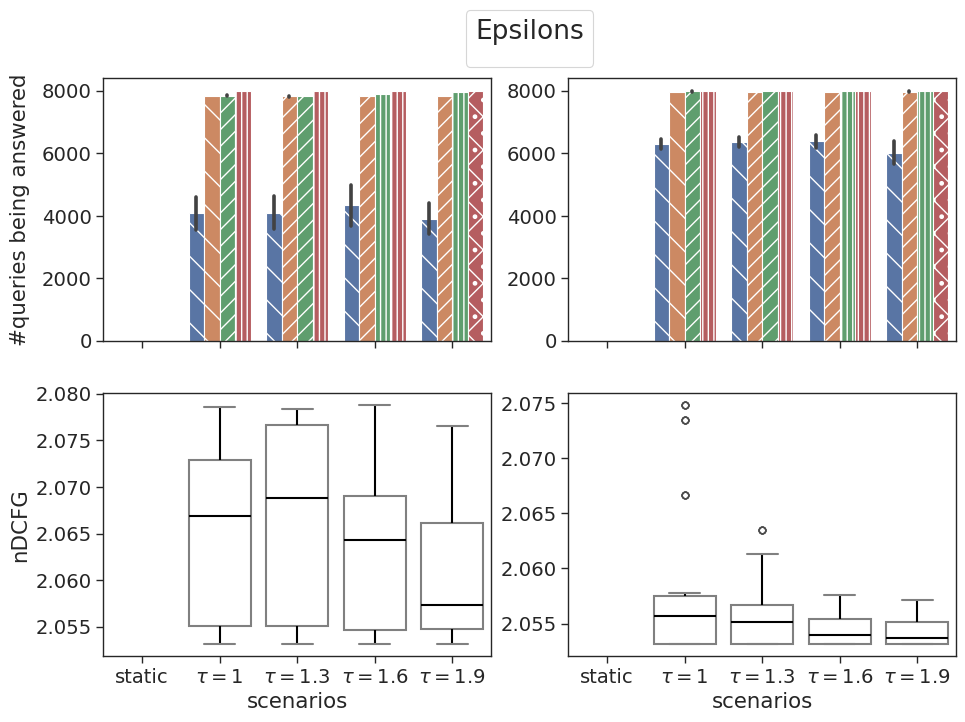

In [13]:
# plotting

# report_truncate = pd.concat([report.iloc[:896], report.iloc[1569:]])
report_fairness_vs_utility = report

# get data
adult_rr_utility = processing_data_fairness(report_fairness_vs_utility, "adult", "RRQ_round-robin", "utility", 8000)
adult_r_utility = processing_data_fairness(report_fairness_vs_utility, "adult", "RRQ_random", "utility", 8000)

adult_rr_utilization = processing_data_fairness(report_fairness_vs_utility, "adult", "RRQ_round-robin", "utilization", 8000)
adult_r_utilization = processing_data_fairness(report_fairness_vs_utility, "adult", "RRQ_random", "utilization", 8000)

adult_rr_fairness = processing_data_fairness(report_fairness_vs_utility, "adult", "RRQ_round-robin", "nDCFG", 8000)
adult_r_fairness = processing_data_fairness(report_fairness_vs_utility, "adult", "RRQ_random", "nDCFG", 8000)


hatches = ['\\', '//', '|||', 'x.']
sns.set(font="Helvetica", rc={"figure.figsize":(4, 3)})
sns.set_theme(style="white")
sns.set_style('ticks')
sns.set_context("paper", font_scale=1.6, rc={"lines.linewidth": 1.75})

# drawing figures
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 7.5))

data = pd.Series(adult_rr_utility).reset_index()
data.columns = ['scenarios', 'epsilons', 'utility']
data = data.explode("utility").reset_index().drop(columns=['index'])
bar = sns.barplot(data=data, x='scenarios', y='utility', hue='epsilons', ax=axes[0][0], )
axes[0][0].set(ylabel="#queries being answered")
axes[0][0].set_xticklabels([])
axes[0][0].set(xlabel=None)
patches = [patch for patch in bar.patches]
h = [hatches[i//(len(patches) // len(hatches))] for i in range(len(patches))]
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)

# get container objects for each hue category
containers = bar.containers

# create legend handles
handles = []
for container in containers:
    for rect in container:
        handles.append(rect)
sns.move_legend(axes[0][0], "lower center", bbox_to_anchor=(1.1, 1), ncol=4, title="Epsilons", frameon=True, handles=containers, fontsize=17, title_fontsize=19)
# sns.move_legend(axes[0][0], "lower center", bbox_to_anchor=(1, 1), ncol=4, title="Epsilons", frameon=True,)


data = pd.Series(adult_r_utility).reset_index()
data.columns = ['scenarios', 'epsilons', 'utility']
data = data.explode("utility").reset_index().drop(columns=['index'])
bar = sns.barplot(data=data, x='scenarios', y='utility', hue='epsilons', ax=axes[0][1], )
axes[0][1].set(ylabel=None)
axes[0][1].set_xticklabels([])
axes[0][1].legend_.remove()
axes[0][1].set(xlabel=None)
patches = [patch for patch in bar.patches]
h = [hatches[i//(len(patches) // len(hatches))] for i in range(len(patches))]
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)



PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'gray'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'gray'}
}
    
data = pd.Series(adult_rr_fairness).reset_index()
data.columns = ['scenarios', 'epsilons', 'nDCFG']
data = data.explode("nDCFG").reset_index().drop(columns=['index'])
sns.boxplot(data=data, x='scenarios', y='nDCFG', linewidth=1.5, ax=axes[1][0], **PROPS)
axes[1][0].set_xticklabels(["static", r"$\tau=1$", r"$\tau=1.3$", r"$\tau=1.6$", r"$\tau=1.9$"])
# axes[2][0].set(xlabel=None)
# patches = [patch for patch in axes[1][0].patches if type(patch) == mpl.patches.PathPatch]
# h = hatches * (len(patches) // 5)
# for patch, hatch in zip(patches, h):
# #     patch.set_hatch(hatch)
#     fc = patch.get_facecolor()
#     patch.set_edgecolor(fc)
#     patch.set_facecolor('none')

    
data = pd.Series(adult_r_fairness).reset_index()
data.columns = ['scenarios', 'epsilons', 'nDCFG']
data = data.explode("nDCFG").reset_index().drop(columns=['index'])
sns.boxplot(data=data, x='scenarios', y='nDCFG', linewidth=1.5, ax=axes[1][1], **PROPS)
axes[1][1].set_xticklabels(["static", r"$\tau=1$", r"$\tau=1.3$", r"$\tau=1.6$", r"$\tau=1.9$"])
axes[1][1].set(ylabel=None)
# patches = [patch for patch in axes[1][1].patches if type(patch) == mpl.patches.PathPatch]
# h = hatches * (len(patches) // 5)
# for patch, hatch in zip(patches, h):
# #     patch.set_hatch(hatch)
#     fc = patch.get_facecolor()
#     patch.set_edgecolor(fc)
#     patch.set_facecolor('none')

fig.align_ylabels()


plt.savefig('fairness.pdf', dpi=600, bbox_inches='tight')


These experiments are done with RRQ workload (of size 4000 * 2). The first row of the figures corresponds to the case that data analysts ask queries in a round-robin manner, while in the experiments with the second row analysts randomly ask queries.

Takeaway messages from the experiments:
1) Dynamically setting view constraints helps in answering more queries, better utlizing privacy budgets, and achieving better fairness scores;
2) Increasing the constraint expansion parameter $\tau$ can result in answering more queries. A relative large gap in utility gain can be observed from graudating setting $\tau=1$ to $1.9$, for all epsilons.
3) A possible reason, as can be observed from the plots in the middle column, for the utility gain, might be that setting an expanded constraint help better utilize the privacy budgets.
4) The price of getting higher utility by setting larger $\tau$ is sacrificing proportional fairness.